# ROS e matlotlib

## Inizializzazione interfaccia Jupyter

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.transforms as mtransforms
from matplotlib.animation import FuncAnimation
import numpy as np
import rospy
import jupyros as jr
import ipywidgets as widgets
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Twist, Pose, Vector3
from std_srvs.srv import SetBool, SetBoolRequest, SetBoolResponse
from tf.transformations import euler_from_quaternion, quaternion_from_euler

# inizializzazione nodo 
rospy.init_node( "jupyter_kernel" )

# subscriber : odometry
last_odom_msg = Odometry( )
dx = 0
dy = 0

def read_odom( msg ):
    '''semplice aggiornamento dell'ultimo messaggio da /odom'''
    global last_odom_msg
    dx = msg.pose.pose.position.x - last_odom_msg.pose.pose.position.x
    dy = msg.pose.pose.position.y - last_odom_msg.pose.pose.position.y
    last_odom_msg = msg
    
odom = rospy.Subscriber( "/odom", Odometry, read_odom )

# publisher : cmd_vel
tw = Twist( )
cmdvel = rospy.Publisher( "/cmd_vel", Twist, queue_size=1000 )

# manual mode
cli_ui_trigger = rospy.ServiceProxy( "/ui_trigger", SetBool )
# cli_ui_trigger( True )

## Impostazione authomatic behaviour

In [3]:
togglebutton_ui_trigger = widgets.ToggleButton( 
    tooltip="allows to turn on/ turn off the authomatic behaviour.",
    description="Authonomous Mode",
    value=False )

mode_manual = True

def change_ui_status( val ):
    '''cambia modalità di funzionamento del robot.
    
    Parameters
    ----------
    val : ???
        se true, viene attivata la modalità manuale
        se false, la modalità viene disattivata
    '''
    
    if val['new']:
        print( "turning on the authonomous mode" )
    else:
        print( "turning off the authonomous mode" )
    
    # se val=true viene attivata la modalità automatica
    cli_ui_trigger( not val['new'] )
    mode_manual = not val['new']

togglebutton_ui_trigger.observe( change_ui_status, names='value' )
display(togglebutton_ui_trigger)

ToggleButton(value=False, description='Authonomous Mode', tooltip='allows to turn on/ turn off the authomatic …

turning on the authonomous mode


# Plot della posizione del robot

## Plot semplice

Aggiungo la nuova posizione ogni volta e aggiorno usando un'animazione con matplotlib. La callback si limita semplicemente a scrivere il nuovo messaggio nella variabile, così da poterlo leggere in ogni momento quando richiesto. 

In [ ]:
%matplotlib notebook

out = widgets.Output( )

fig, ax = plt.subplots( )

x = []
y = []

area = 6.5
trajectory, = ax.plot( x, y, '-r' )
ax.set_xlim( -area, area )
ax.set_ylim( -area, area )
ax.grid( True )
display( out )

def update_position( frame ):
    '''leggi la posizione attuale e aggiungila alla traiettoria'''
    
    global x, y, trajectory, last_odom_msg, out
    
    newPos = last_odom_msg.pose.pose.position
    x.append( newPos.x )
    y.append( newPos.y )
    
    out.clear_output( )
    with out:
        print( newPos )
    
    trajectory.set_data( x, y )
    
    return trajectory,

def init_animation( ):
    '''inizlalizza il grafico, segnando la prima posizione'''
    
    global x, y, trajectory, out
    
    pos = last_odom_msg.pose.pose.position
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    return trajectory,

anim = mpl.animation.FuncAnimation( 
    fig, update_position, interval=125, blit=True, save_count = True, init_func=init_animation )

# plt.show( )

## Plot con orientation

Una freccia adesso indica l'orientazione attuale del robot. 

In [ ]:


from tf.transformations import euler_from_quaternion, quaternion_from_euler

wtext = widgets.Label( value="---" )
display( wtext )
fig, ax = plt.subplots( )

x = []
y = []

area = 6.5
trajectory, = ax.plot( x, y, '-r' )
arrow_pos = patch.Arrow( 0, 0, 1, 0 )
ax.set_xlim( -area, area )
ax.set_ylim( -area, area )
ax.grid( True )

def update_position( frame ):
    '''leggi la posizione attuale e aggiungila alla traiettoria'''
    
    global x, y, trajectory, last_odom_msg, ax, arrow_pos, wtext
    
    tw = last_odom_msg.twist.twist
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot ), np.sin( rot ), -np.sin( rot ), np.cos( rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    
    wtext.value = f"pos({pos.x:.2f}m, {pos.y:.2f}m) th({rot:.2f}rad) -- twist({tw.linear.x:.2f}m/s, {tw.linear.y:.2f}m/s, {tw.angular.z:.2f}rad/s)"
    
    return (trajectory, arrow_pos)

def init_animation( ):
    '''inizlalizza il grafico, segnando la prima posizione'''
    
    global x, y, trajectory, ax, arrow_pos
    
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot ), np.sin( rot ), -np.sin( rot ), np.cos( rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    ax.add_patch( arrow_pos )
    
    return (trajectory, arrow_pos)

anim = mpl.animation.FuncAnimation( 
    fig, update_position, interval=125, blit=True, save_count = True, init_func=init_animation )

# plt.show( )

## Plot con twist

Il grafico aggiune una freccia che indica la velocità attuale del robot e la sua velocità angolare. 

- Velocità lineare: nella direzione del robot
- velocità angolare: la freccia viene deflessa rispetto alla direzione frontale nel senso della rotazione

Usa l'arcotangente per variare l'angolo del vettore in base alla velocità angolare. 


Label(value='---')

<IPython.core.display.Javascript object>


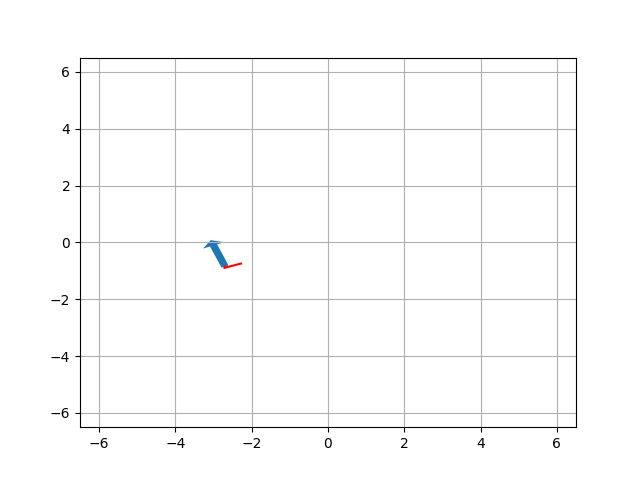

In [20]:
from tf.transformations import euler_from_quaternion, quaternion_from_euler

wtext = widgets.Label( value="---" )
display( wtext )
fig, ax = plt.subplots( )

x = []
y = []

area = 6.5
trajectory, = ax.plot( x, y, '-r' )
arrow_pos = patch.Arrow( 0, 0, 1, 0 )
ax.set_xlim( -area, area )
ax.set_ylim( -area, area )
ax.grid( True )

def update_position( frame ):
    '''leggi la posizione attuale e aggiungila alla traiettoria'''
    
    global x, y, trajectory, last_odom_msg, ax, arrow_pos, wtext
    
    tw = last_odom_msg.twist.twist
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    tw_rot = np.arctan( last_odom_msg.twist.twist.angular.z )
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot + tw_rot ), np.sin( rot + tw_rot ), -np.sin( rot + tw_rot ), np.cos( rot + tw_rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    
    wtext.value = f"pos({pos.x:.2f}m, {pos.y:.2f}m) th({rot:.2f}rad) -- twist({tw.linear.x:.2f}m/s, {tw.linear.y:.2f}m/s, {tw.angular.z:.2f}rad/s)"
    
    return (trajectory, arrow_pos)

def init_animation( ):
    '''inizlalizza il grafico, segnando la prima posizione'''
    
    global x, y, trajectory, ax, arrow_pos
    
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    tw_rot = np.arctan( last_odom_msg.twist.twist.angular.z )
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot + tw_rot ), np.sin( rot + tw_rot ), -np.sin( rot + tw_rot ), np.cos( rot + tw_rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    ax.add_patch( arrow_pos )
    
    return (trajectory, arrow_pos)

anim = mpl.animation.FuncAnimation( 
    fig, update_position, interval=125, blit=True, save_count = True, init_func=init_animation )

# plt.show( )